# COMPONENT 1 - WEB SCRAPING MODULE

### IMPORTING THE LIBRARIES

In [ ]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
import numpy as np
import re
import os

In [78]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

## EXTRACTING NEWS DATA FOR TWO WEEKS (Feb 1, 2021 to Feb 14, 2021)

### LIST OF URLS OF 14 DAYS:

The urls of the web pages are as follows:

https://www.thehindu.com/archive/web/2021/02/01/

https://www.thehindu.com/archive/web/2021/02/02/ 

................

https://www.thehindu.com/archive/web/2021/02/14/

Since the urls follow a similar pattern, we can create the list of all the urls as follows:

In [ ]:
num_list = [ "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]

In [ ]:
webpage_links = []
for i in range(len(num_list)):
  link = "https://www.thehindu.com/archive/web/2021/02/{0}/".format(num_list[i])
  webpage_links.append(link)

In [ ]:
webpage_links

### CREATING A LIST OF ALL THE URLS FROM THE WEBPAGES OF 14 DAYS:
### FROM FEB 1, 2021 TO FEB 14, 2021


In [ ]:
URL_list = []
for link in webpage_links:
  page = requests.get(link)
  soup = BeautifulSoup(page.content, "html.parser")
  for item in soup.find_all(attrs={'class':'archive-list'}):
    for link in item.find_all(href=True):
        href=link.get('href')
        URL_list.append(href)

In [ ]:
len(URL_list)

### CREATING A LIST OF JSON FILES

In [ ]:
json_files = []
for i in range(len(URL_list)):
  json_files.append('thehindu_feb_02_file_{0}.json'.format(i))

### EXTRACTING THE USEFUL CONTENT FROM THE URLs:

In [ ]:
for i in range(len(URL_list)):
  news_data = {"text" : []}
  page = requests.get(URL_list[i])
  soup = BeautifulSoup(page.content, "html.parser")

#SCRAPING THE TITLE OF THE WEBPAGE
  title = soup.find('h1')
  if title!= None:
    news_data["text"].append(title.text)

#SCRAPING THE SUB TITLE OF THE WEBPAGE
  sub_title = soup.find_all('h2')
  if sub_title != None:
    for st in sub_title:
      news_data["text"].append(st.text)

      
#SCRAPING CONTENT FROM PARAGRAPH TAGS WITH A SPECIFIC ID
  regex = re.compile('.*content-body-.*')
  for item in soup.find_all("div", {'id': regex}):
    for p in item.find_all('p'):
      news_data["text"].append(p.text)  

#STORING THE CONTENT FROM EACH WEBPAGE IN A SEPARATE JSON FILE
  with open(json_files[i], 'w') as jsonfile:
    json.dump(news_data, jsonfile)

#SAVING THE JSON FILES IN GOOGLE DRIVE
  !cp {json_files[i]} /content/drive/MyDrive/JSON_FILES2


### STORING THE TEXT FROM EACH FILE IN A LIST

In [ ]:
raw_text = []
for js in json_files:
   with open(js) as json_file:
        json_text = json.load(json_file)
        raw_text.append(json_text['text'])

### SAVING THE RAW TEXT IN A SEPARATE .JSON FILE

In [ ]:
#To save the data from Feb 1 to Feb 7
with open('raw_text_01.json', 'w') as jsonfile:
   json.dump(raw_text, jsonfile)
!cp raw_text_01.json /content/drive/MyDrive/RAW_TEXT

In [ ]:
#To save the data from Feb 8 to Feb 14
with open('raw_text_02.json', 'w') as jsonfile:
    json.dump(raw_text, jsonfile)
!cp raw_text_02.json /content/drive/MyDrive/RAW_TEXT

## CREATING A DATAFRAME TO STORE THE FILE NAMES AND THE CORRESPONDING URLs

In [ ]:
tab_head = ["File_Scraped", "Corresponding URL"]
df_data = pd.DataFrame(zip(json_files, URL_list), columns = tab_head)
df_data[:10]

### STORING THE DATAFRAME IN .CSV FILE

In [ ]:
df_data.to_csv('URLs_to_file_mapping.csv', sep ='|')
!cp URLs_to_file_mapping.csv /content/drive/MyDrive/CSV_FILES

### DISPLAYING THE CONTENT IN .CSV FILE

In [ ]:
new_df = pd.read_csv('URLs_to_file_mapping.csv')
new_df.head(10)

In [ ]:
new_df.shape

### VIEWING THE RAW DATA

In [ ]:
raw_text = []
f1 = open("/content/drive/MyDrive/RAW_TEXT/raw_text_01.json")
data1 = json.load(f1)
for i in data1:
  raw_text.append(i) 

f2 = open("/content/drive/MyDrive/RAW_TEXT/raw_text_02.json")
data2 = json.load(f2)
for i in data2:
  raw_text.append(i)

In [ ]:
len(raw_text)

5565

## OUTLIERS DETECTION AND REMOVAL

CALCULATING THE LENGTH OF ALL THE FILES

In [ ]:
length = []
for files in raw_text:
  c = len(str(files).split())
  length.append(c)

VISUALISING USING BOX PLOT

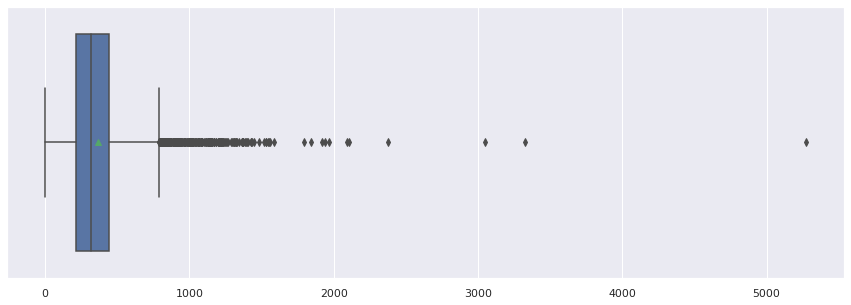

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(length, width = 0.8, showmeans = True)

DETECTING THE OUTLIERS

In [ ]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [5, 95])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
    print("Lower Bound: ", lower_bound)
    print("Upper Bound: ",upper_bound)
    return outliers
 
# input data
detect_outlier((length))

Lower Bound:  -897.2000000000003
Upper Bound:  1786.0000000000005


[5274, 2093, 2374, 3324, 1793, 2109, 1845, 1943, 1922, 3047, 1965]

OUTLIERS REMOVAL

In [ ]:
#Removing the text having length greater than 1786 words
modified_text = []
for text in raw_text:
  c = len(str(text).split())
  if c <= 1786:
    modified_text.append(text)
len(modified_text)

5554

BOX PLOT

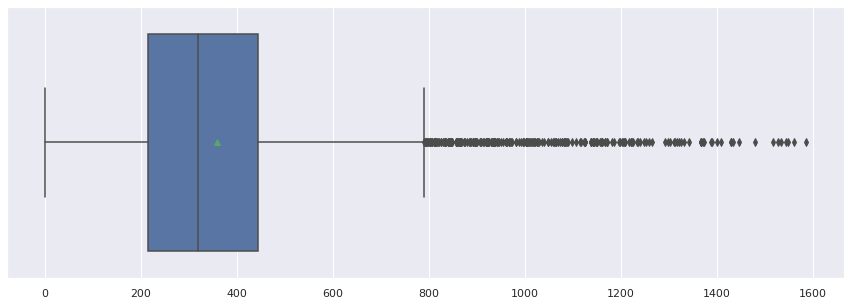

In [ ]:
length = [i for i in length if i < 1786]
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(length, width = 0.8, showmeans=True)

# Component 2 - Topic Model

## DATA PREPROCESSING

In [ ]:
#FOR STOP WORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#FOR LEMMATIZATION
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#FOR STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

#FOR BIGRAMS
from nltk.util import bigrams
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### PERFORMING THE TEXT PREPROCESSING

In [ ]:
def data_preprocessing(raw_text):
  filtered_text = []     #TO STORE THE PROCESSED DATA    
  for t in raw_text:
    filtered_sentence = ""
    stemmed_list = []
    lemmatized_list = []
    
    sentence = str(t)
    # Remove new line characters
    for word in sentence:
      word = word.strip()

    #Data Cleansing
    sentence = re.sub(r'[^\w\s]', ' ', sentence)


    #Removing numbers
    sentence = re.sub(r'[0-9]', '', sentence)
    
    #Tokenization
    words = nltk.word_tokenize(sentence)

    #Lowercase
    for word in words:
      word.lower()
    
    #Stop words removal
    words = [w for w in words if not w in stop_words]
    
    #Stemming
    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_list.append(stemmed_word)
        
    #Lemmatization
    for s_word in stemmed_list:
        lemmatized_word = lemmatizer.lemmatize(s_word)
        lemmatized_list.append(lemmatized_word)

    
    lemmatized_list = [i for i in lemmatized_list if len(i) > 3]
    
    filtered_text.append(lemmatized_list)
  return filtered_text

In [ ]:
filtered_text = data_preprocessing(modified_text)

### FREQUENCY DISTRIBUTION PLOT

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist

In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [ ]:
words_list = []
for line in filtered_text:
  for word in line:
    words_list.append(word)

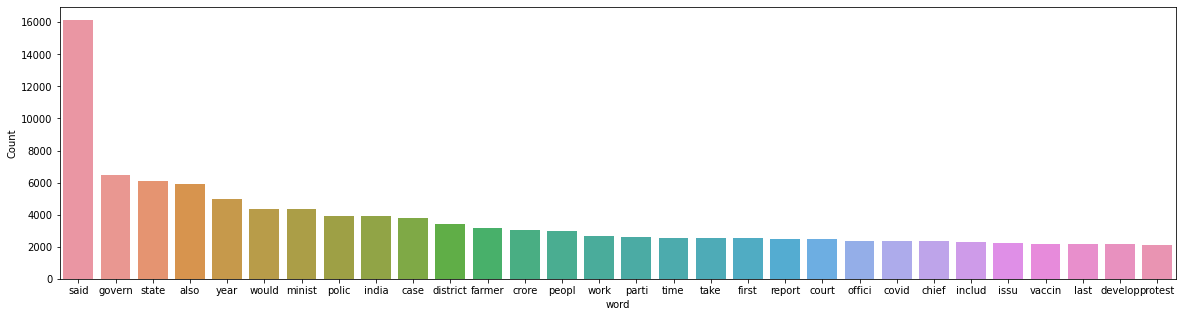

In [ ]:
freq_words(words_list)

Extending the stop words list:

In [ ]:
extra_stopwords = ['crore', 'first', 'said', 'work', 'also', 'case', 'would', 'take', 'time', 'last', 'year', 'three', 'make', 'nthe', 'need', 'even',
                   'issu', 'well', 'come', 'made', 'come', 'howev', 'work', 'februari', 'includ','like']
stop_words.extend(extra_stopwords)

In [ ]:
words_list = [w for w in words_list if not w in stop_words]

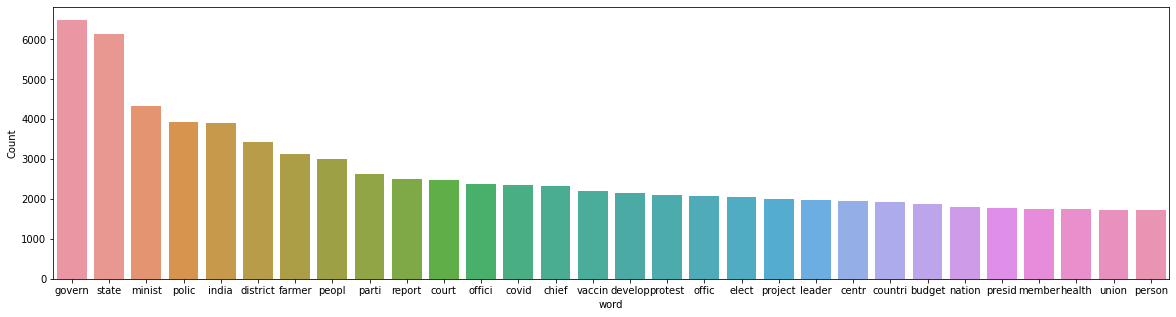

In [ ]:
freq_words(words_list)

In [ ]:
filtered_text2 = []
for sentence in filtered_text:
  sentence = [w for w in sentence if not w in extra_stopwords]
  filtered_text2.append(sentence)

In [ ]:
len(filtered_text2)

5554

### WORD CLOUD

In [ ]:
words_string = " ".join(words_list)

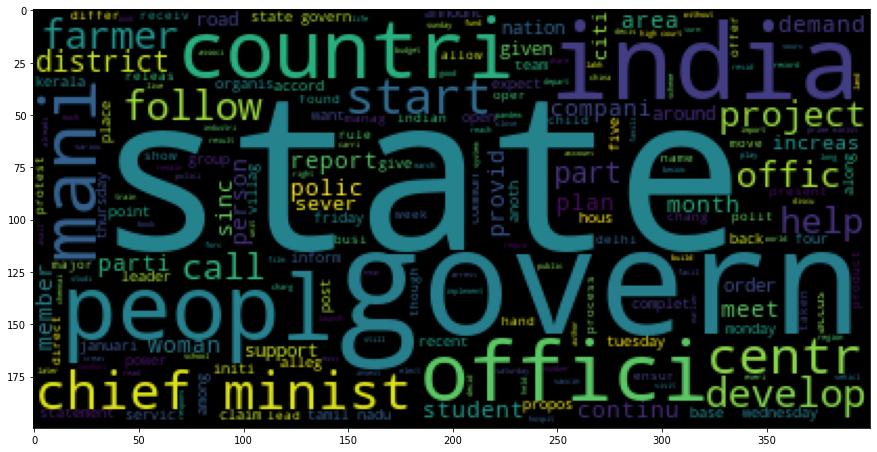

In [ ]:
import wordcloud

wordcloud = wordcloud.WordCloud()
wordcloud.generate(words_string)
plt.figure( figsize=(15,10) )
plt.rcParams["axes.grid"] = False
plt.imshow(wordcloud)

### BIGRAMS AND TRIGRAMS FORMATION

In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(filtered_text2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[filtered_text2])  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
for i in range(len(filtered_text2)):
    print(trigram_mod[bigram_mod[filtered_text2[i]]])

### FREQUENCY DISTRIBUTION OF BIGRAMS:

In [22]:
import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

word_fd = nltk.FreqDist(words_list)
bigram_fd = nltk.FreqDist(nltk.bigrams(words_list))

bigram_fd.most_common()[:25]

[(('chief', 'minist'), 1288),
 (('state', 'govern'), 841),
 (('tamil', 'nadu'), 786),
 (('high', 'court'), 613),
 (('prime', 'minist'), 599),
 (('social', 'medium'), 445),
 (('suprem', 'court'), 394),
 (('financ', 'minist'), 379),
 (('covid', 'vaccin'), 349),
 (('farmer', 'protest'), 342),
 (('union', 'budget'), 321),
 (('rajya', 'sabha'), 314),
 (('test', 'posit'), 292),
 (('polic', 'station'), 283),
 (('uttar', 'pradesh'), 280),
 (('andhra', 'pradesh'), 276),
 (('narendra', 'modi'), 267),
 (('covid', 'pandem'), 251),
 (('central', 'govern'), 245),
 (('west', 'bengal'), 230),
 (('told', 'hindu'), 228),
 (('minist', 'narendra'), 227),
 (('frontlin', 'worker'), 227),
 (('gener', 'secretari'), 222),
 (('medic', 'colleg'), 217)]

### FREQUENCY DISTRIBUTION OF TRIGRAMS:

In [23]:
trigrams=ngrams(words_list,3)
trigram_fd = nltk.FreqDist(trigrams)
trigram_fd.most_common()[:20]

[(('minist', 'narendra', 'modi'), 209),
 (('prime', 'minist', 'narendra'), 207),
 (('financ', 'minist', 'nirmala'), 170),
 (('minist', 'nirmala', 'sitharaman'), 169),
 (('bharatiya', 'janata', 'parti'), 121),
 (('former', 'chief', 'minist'), 117),
 (('jagan', 'mohan', 'reddi'), 113),
 (('chief', 'minist', 'edappadi'), 108),
 (('minist', 'edappadi', 'palaniswami'), 108),
 (('subscrib', 'today', 'cach'), 105),
 (('today', 'cach', 'newslett'), 105),
 (('cach', 'newslett', 'quick'), 105),
 (('newslett', 'quick', 'snapshot'), 105),
 (('quick', 'snapshot', 'tech'), 105),
 (('snapshot', 'tech', 'stori'), 105),
 (('tech', 'stori', 'click'), 105),
 (('stori', 'click', 'subscrib'), 102),
 (('click', 'subscrib', 'free'), 102),
 (('medic', 'colleg', 'hospit'), 91),
 (('madra', 'high', 'court'), 85)]

## SPLITTING THE DATA INTO TRAINING SET AND TEST SET

In [24]:
import random
random.shuffle(filtered_text2)

In [25]:
from sklearn.model_selection import train_test_split
training_set, test_set  = train_test_split(filtered_text2, test_size=0.1, random_state = 0)

In [26]:
len(training_set)

4998

In [82]:
len(test_set)

556

# TOPIC MODELING

## LDA MODEL

In [ ]:
#IMPORTING THE LIBRARIES
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
pip install pyLDAvis

In [31]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
id2word = corpora.Dictionary(training_set)

# Create Corpus
texts = training_set

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [33]:
len(corpus)

4998

### TERM FREQUENCY

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## BUILDING THE LDA TOPIC MODEL

In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=42,
                                           iterations = 50,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           decay = 0.5,
                                           alpha='auto',
                                           per_word_topics=True)

### Computing Model Perplexity and Coherence Score

NUM TOPICS = 25

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=training_set, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.076700204492523

Coherence Score:  0.5887941443794795


NUM TOPICS = 15

In [38]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=42,
                                           iterations = 50,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           decay = 0.5,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model2, texts=training_set, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.114937191960857

Coherence Score:  0.5265824481131284


NUM TOPICS = 20

In [39]:
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=42,
                                           iterations = 50,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           decay = 0.5,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model3.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model3, texts=training_set, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.109970222450189

Coherence Score:  0.528405792059452


## LDA MALLET

In [40]:
import os
def install_java_jdk():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version

install_java_jdk

<function __main__.install_java_jdk>

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive

Mounted at /content/gdrive
/content/gdrive


In [43]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

### COMPUTING COHERENCE VALUE FOR LDA MALLET

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=training_set, start=5, limit=80, step=5)

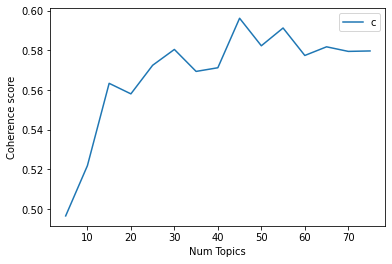

In [46]:
# Show graph
import matplotlib.pyplot as plt
limit=80; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 5  has Coherence Value of 0.497
Num Topics = 10  has Coherence Value of 0.522
Num Topics = 15  has Coherence Value of 0.563
Num Topics = 20  has Coherence Value of 0.558
Num Topics = 25  has Coherence Value of 0.572
Num Topics = 30  has Coherence Value of 0.58
Num Topics = 35  has Coherence Value of 0.569
Num Topics = 40  has Coherence Value of 0.571
Num Topics = 45  has Coherence Value of 0.596
Num Topics = 50  has Coherence Value of 0.582
Num Topics = 55  has Coherence Value of 0.591
Num Topics = 60  has Coherence Value of 0.577
Num Topics = 65  has Coherence Value of 0.582
Num Topics = 70  has Coherence Value of 0.579
Num Topics = 75  has Coherence Value of 0.58


### BUILDING THE LDA MALLET MODEL

In [48]:
ldamallet1 = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 35, id2word = id2word)

In [49]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet1, texts=training_set, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5750267006636408


NUM TOPICS = 30

In [50]:
ldamallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 30, id2word = id2word)
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet2, texts=training_set, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5854787826967935


Out of all the models, LDA Model with number o topics = 25 has the best performance with Coherence Score: 0.58879 . Thus, we proceed furthur with the same model.

## VIEWING THE TOPICS IN LDA MODEL

In [53]:
# Print the Keyword in the topics
from pprint import pprint
pprint(lda_model.print_topics(num_words=15))
doc_lda = lda_model[corpus]

[(18,
  '0.015*"water" + 0.014*"uttarakhand" + 0.013*"glacier" + 0.012*"flood" + '
  '0.010*"project" + 0.008*"river" + 0.008*"disast" + 0.007*"rescu" + '
  '0.007*"tunnel" + 0.007*"burst" + 0.006*"caus" + 0.006*"peopl" + '
  '0.006*"ganga" + 0.005*"lake" + 0.005*"level"'),
 (6,
  '0.025*"wast" + 0.011*"fish" + 0.010*"bitcoin" + 0.009*"boat" + '
  '0.008*"pollut" + 0.008*"tonn" + 0.007*"mine" + 0.007*"cultiv" + '
  '0.007*"port" + 0.007*"garbag" + 0.006*"song" + 0.006*"musician" + '
  '0.006*"board" + 0.005*"manag" + 0.005*"iran"'),
 (9,
  '0.016*"china" + 0.012*"militari" + 0.011*"biden" + 0.011*"myanmar" + '
  '0.010*"trump" + 0.009*"presid" + 0.009*"countri" + 0.008*"call" + '
  '0.007*"nation" + 0.007*"state" + 0.006*"democraci" + 0.006*"coup" + '
  '0.006*"chine" + 0.005*"secur" + 0.005*"right"'),
 (24,
  '0.019*"elect" + 0.019*"appoint" + 0.018*"state" + 0.015*"kumar" + '
  '0.012*"pradesh" + 0.011*"post" + 0.011*"commiss" + 0.009*"secretari" + '
  '0.008*"govern" + 0.008*"rank" 

### VISUALISE TOPICS

In [ ]:
!pip install pandas --upgrade

In [ ]:
# Visualize the topics
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

## Word Clouds of Top N Keywords in Each Topic

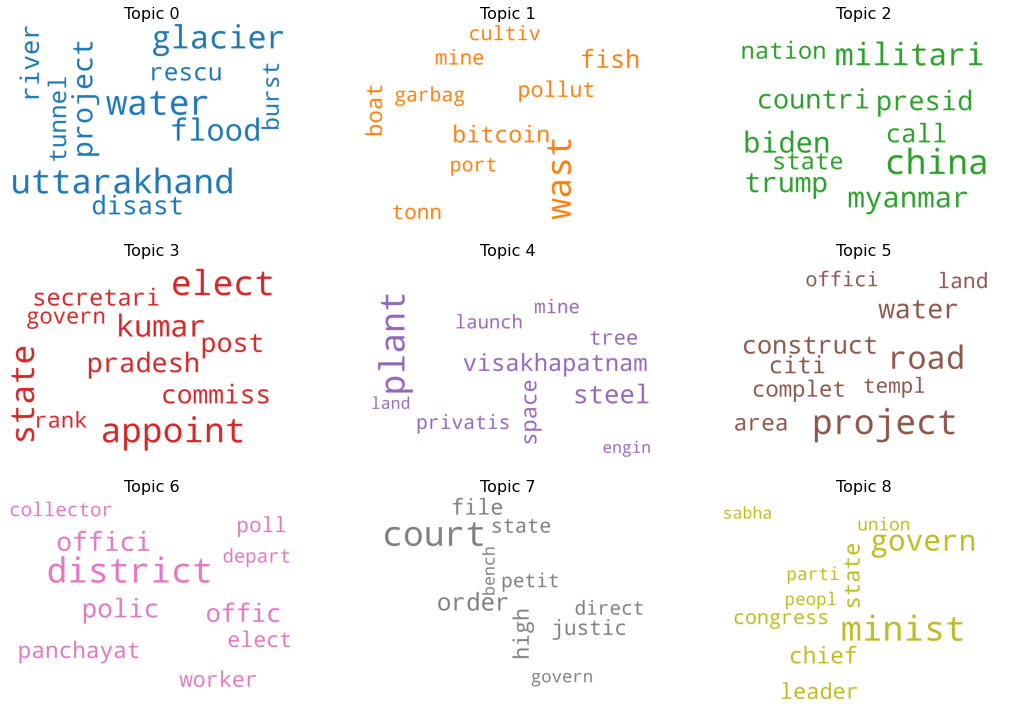

In [69]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  contour_color='steelblue',
                  color_func=lambda *args, **kwargs: cols[i])

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3 ,3 , figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=20, hspace=20)
plt.axis('off')
plt.margins(x=10, y=10)
plt.tight_layout()
plt.show()

## TESTING THE MODEL ON TEST SET

### TOPIC DISTRIBUTION FOR TEST SET

In [91]:
Topic_distribution= []
for i in range(20):
  print(lda_model[id2word.doc2bow(test_set[i])][0])
  Topic_distribution.append(lda_model[id2word.doc2bow(test_set[i])][0])

[(1, 0.021897769), (4, 0.07518574), (5, 0.16949579), (6, 0.018895892), (7, 0.09890124), (11, 0.24478309), (13, 0.045365896), (14, 0.024246465), (18, 0.022087427), (19, 0.069728516), (20, 0.012212378), (21, 0.01907246), (23, 0.15966427)]
[(1, 0.04337557), (3, 0.14325933), (5, 0.09916433), (6, 0.015025946), (12, 0.047047164), (15, 0.049323536), (17, 0.012777295), (20, 0.17104426), (23, 0.40683654)]
[(3, 0.04374689), (5, 0.25362188), (11, 0.032298096), (12, 0.31659725), (19, 0.2995553), (23, 0.024593513)]
[(3, 0.034061413), (4, 0.027197074), (6, 0.11056123), (7, 0.27859458), (10, 0.039716024), (11, 0.0484012), (13, 0.06324243), (14, 0.18221276), (15, 0.038616315), (16, 0.11004302), (23, 0.045841396), (24, 0.017867036)]
[(2, 0.41283247), (4, 0.047349323), (8, 0.020200476), (11, 0.05742177), (12, 0.3855417), (13, 0.047128167), (15, 0.014068604)]
[(0, 0.05914321), (1, 0.031064956), (2, 0.39787608), (9, 0.057381764), (11, 0.018776713), (12, 0.3073655), (13, 0.020184914), (14, 0.024820061), (2